# Plot SSH and f/H contours in NW2

In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np

## Open NW2 data

In [2]:
exp_list = [
    r'$1/4^\circ$', 
    r'$1/8^\circ$', 
    r'$1/16^\circ$', 
    r'$1/32^\circ$'
]
run_list = [
    'baselines/nw2_0.25deg_N15_baseline_hmix5',
    'baselines/nw2_0.125deg_N15_baseline_hmix5',
    'baselines/nw2_0.0625deg_N15_baseline_hmix5',
    'baselines/nw2_0.03125deg_N15_baseline_hmix5'
]

In [3]:
chunks = {'time': 1}
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2'

av_list = []
st_list = []

for run in run_list:
    av = xr.open_mfdataset('%s/%s/longmean_*.nc' % (path, run), chunks=chunks, decode_times=False)
    av_list.append(av)
    print('AV 1/%i nt=%i ts=%f te=%f'%(len(av.xh)//60,len(av.time),av.time[0],av.time[-1]))

    st = xr.open_dataset('%s/%s/static.nc' % (path, run), decode_times=False)
    st_list.append(st)

AV 1/4 nt=320 ts=50.000000 te=31950.000000
AV 1/8 nt=50 ts=50.000000 te=4950.000000
AV 1/16 nt=50 ts=50.000000 te=4950.000000
AV 1/32 nt=28 ts=50.000000 te=2750.000000


## Compute SSH and total depth

In [4]:
for av, st in zip(av_list, st_list):
    av['ssh_mean'] = av['e'].isel(zi=0,time=slice(-6,None)).mean(dim='time').compute()
    #This tells the grid where xh, xq, yh, and yq are defined.
    grid= Grid(st, coords={'X': {'center': 'xh', 'outer': 'xq'}, 
                        'Y': {'center': 'yh', 'outer': 'yq'}});
    st['f_h'] = (grid.interp(st.Coriolis,axis=['X','Y'])/st.depth_ocean) * 1e8
    st['f_h'] = st['f_h'].where(st.wet)

## Plot

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 20}
pylab.rcParams.update(params)

In [9]:
import warnings
warnings.filterwarnings("ignore")

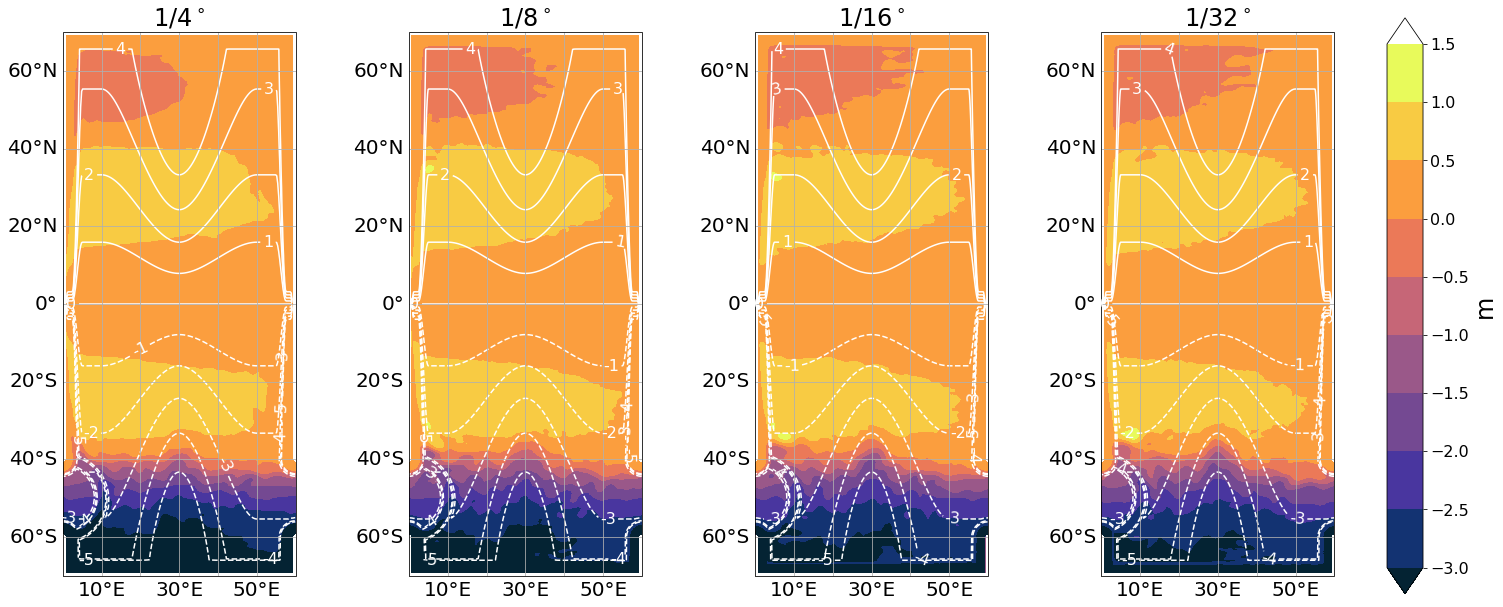

In [31]:
# time averages
vmin = -3.
vmax = 1.2
ci = .5
elevs = np.arange(vmin,vmax+ci,ci)
flevs = np.arange(-5,5,1)
unit = 'm'

fig,axs = plt.subplots(1,4,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})

for exp, av, st, ax in zip(exp_list, av_list, st_list, axs.flatten()):
    p = av['ssh_mean'].plot( #av['e'].isel(zi=0,time=slice(-10,None)).mean(dim='time').plot(
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        levels=elevs,
        cmap=cmocean.cm.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )
    CS = st['f_h'].plot.contour(
        ax=ax, 
        levels=flevs, 
        vmin=-5, 
        vmax=5, 
        colors='w',
        linewidth=0.1
    )
    ax.clabel(CS, flevs, inline=True, fontsize=16, fmt='%1.0f', colors='w')
    
    ax.set(title=exp)
    ax.set_extent([0, 60, -70, 70], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.2)
cax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cax, label=unit, extend='both')
cbar.ax.tick_params(labelsize=16) 

plt.savefig('mean_SSH.png', bbox_inches='tight', pad_inches=0)